In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


data_base = mysql.connector.connect(host = 'localhost',
                                   username = 'root',
                                   password = 'Rammishra@1',
                                   database = 'ecommarce')

cur = data_base.cursor()

# List all unique cities where customers are located.

In [14]:
query = """
select distinct customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['custmer_city'])
df.head()

,custmer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [13]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017
"""

cur.execute(query)

data = cur.fetchall()

'Total orders placed in 2017',data[0][0]


('Total orders placed in 2017', 45101)

# Find the total sales per category.

In [3]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales 
from products join order_items on 
products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame( data , columns = ['category', 'sales'])

df.head()



,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments. 

In [29]:
query = """select sum(case when payment_installments >= 1 then 1 else 0 end)/ count(*)*100 from payments

"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

#  Count the number of customers from each state.

<function matplotlib.pyplot.show(close=None, block=None)>

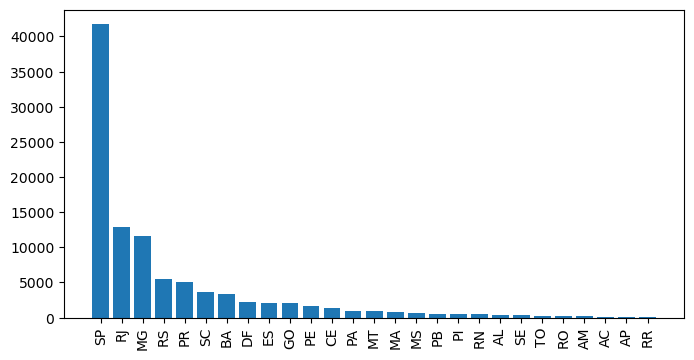

In [4]:
query = """select customer_state ,count(customer_id)from customers

group by customer_state

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values(by = 'customer_count', ascending= False)

plt.figure(figsize = (8,4))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.show


# Calculate the number of orders per month in 2018.

<function matplotlib.pyplot.show(close=None, block=None)>

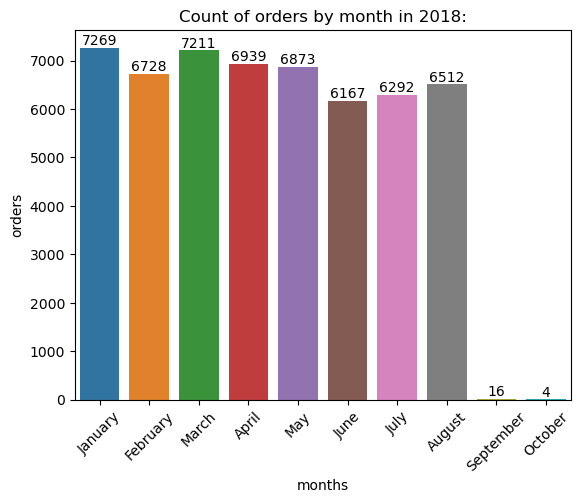

In [13]:
query = """select monthname(order_purchase_timestamp) months,count(order_id) orders_counts from orders
where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ['months' , 'orders'])
df
oo = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x=df["months"], y=df["orders"], data=df, order=oo)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])  # Corrected 'bar_lable' to 'bar_label'
plt.title("Count of orders by month in 2018:")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [28]:
query = """with count_per_orders as
(select orders.order_id, orders.customer_id , count( order_items.order_id) as total_counts
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)



select customers.customer_city, round(avg(count_per_orders.total_counts),2) average_of_orders
from customers join count_per_orders
on customers.customer_id = count_per_orders.customer_id
group by customers.customer_city order by average_of_orders desc

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data ,columns = ['city', 'avg_product_order'] )
df.head(10)

,city,avg_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [32]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value)/ (select sum(payment_value) from payments)*100,2) sales 
from products join order_items on 
products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by  sales desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame( data , columns = ['category', 'parcentage_of_total_revenue'])

df.head(10)

,category,parcentage_of_total_revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [39]:
query = """select products.product_category , count(order_items.product_id),
round(avg(order_items.price), 2)
from products join order_items 
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame( data , columns = ['category ' , "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

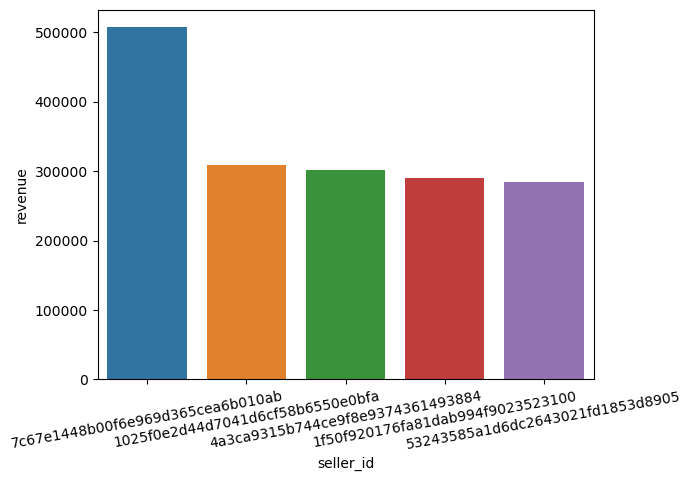

In [56]:
query = """select * , dense_rank() over (order by revenue desc) as drn from 
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data , columns = ['seller_id' , 'revenue', 'rank'])
df = df.head()

sns.barplot(x = 'seller_id', y = 'revenue', data = df)
plt.xticks(rotation = 10)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [6]:
query = """ select customer_id, order_purchase_timestamp, payment, avg(payment)
over(partition  by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_average
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment 
from orders join payments
on payments.order_id = orders.order_id) as a
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [27]:
query = """ select years, months,payments, sum(payments)
over(order by years , months)
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(15)

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [39]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payments
from orders join payments
on orders.order_id = payments.order_id
group by years order by years) 

select years , ((payments - lag(payments,1) over(order by years))/
lag(payments , 1) over(order by years)) * 100 from a



"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['years', 'yoy % growth '])
df.head()

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

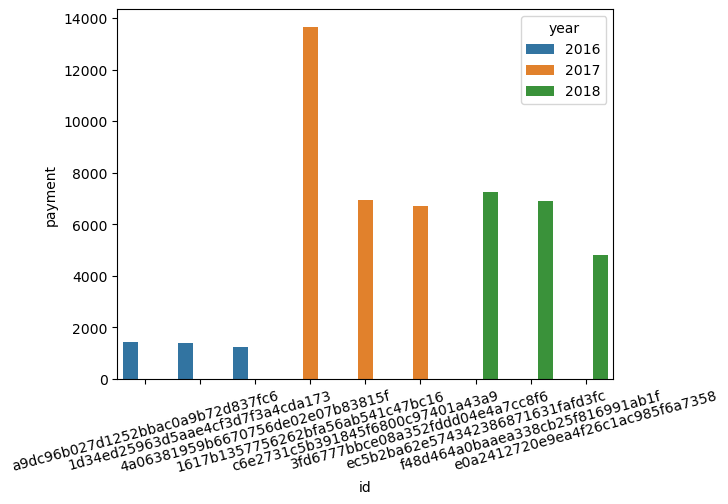

In [11]:
query = """select years, customer_id, payment , d_rank
from
(select year(orders.order_purchase_timestamp) years, orders.customer_id,
sum(payments.payment_value) payment, 
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order  by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp), 
orders.customer_id) as a
where d_rank <= 3;

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year','id','payment', 'rank'])
sns.barplot(x = "id", y = 'payment', data = df , hue = 'year')
plt.xticks(rotation = 15)
plt.show()